# Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdflib

In [2]:
g = rdflib.Graph()
g.parse("ghc_brick.ttl", format="ttl")

<Graph identifier=Ne12d43b066fd4f5089ef03a348dfc1e5 (<class 'rdflib.graph.Graph'>)>

In [3]:
query_ = """
SELECT ?o (count(*) AS ?cnt)
WHERE { 
     ?s a ?o .
}
GROUP BY ?o
ORDER BY DESC(?cnt)
LIMIT 10
"""

q_res = g.query(query_)
print("({}) majority types(descending):\n--------------------------------".format(len(q_res)))
for row in q_res:
        print("""({}) subjects of type: [{}]
        """.format(row.cnt, row.o)) 

(10) majority types(descending):
--------------------------------
(9633) subjects of type: [http://www.w3.org/2002/07/owl#NamedIndividual]
        
(936) subjects of type: [https://brickschema.org/schema/Brick#Discharge_Air_Flow_Setpoint]
        
(613) subjects of type: [https://brickschema.org/schema/Brick#Command]
        
(493) subjects of type: [https://brickschema.org/schema/Brick#Run_Time_Sensor]
        
(490) subjects of type: [https://brickschema.org/schema/1.0.2/Brick#Schedule_Setpoint]
        
(485) subjects of type: [https://brickschema.org/schema/Brick#Discharge_Air_Temperature_Sensor]
        
(481) subjects of type: [https://brickschema.org/schema/Brick#Cooling_Temperature_Setpoint]
        
(481) subjects of type: [https://brickschema.org/schema/Brick#Heating_Temperature_Setpoint]
        
(475) subjects of type: [https://brickschema.org/schema/Brick#HVAC_Zone]
        
(475) subjects of type: [https://brickschema.org/schema/Brick#Room]
        


### List types of interest

In [4]:
# get 'Discharge_Air_Flow_Sensor' entities 

query_ = """
SELECT ?s
WHERE { 
     ?s a brick:Discharge_Air_Flow_Sensor .
}

"""

q_res = g.query(query_)
ls_disAirFlowSens = [row.s.rstrip() for row in q_res] 
len(ls_disAirFlowSens)

462

In [5]:
# get 'Damper_Position_Sensor' entities 

query_ = """
SELECT ?s
WHERE { 
     ?s a brick:Damper_Position_Sensor .
}

"""

q_res = g.query(query_)
ls_DamPosSens = [row.s.rstrip() for row in q_res] 
len(ls_DamPosSens)

472

In [6]:
# get 'Room' entities 

query_ = """
SELECT ?s
WHERE { 
     ?s a brick:Room .
}

"""

q_res = g.query(query_)
ls_room = [row.s.rstrip() for row in q_res] 
len(ls_room)

475

In [7]:
# get 'VAV' entities 

query_ = """
SELECT ?s
WHERE { 
     ?s a brick:VAV .
}

"""

q_res = g.query(query_)
ls_vav = [row.s.rstrip() for row in q_res] 
len(ls_vav)

447

# Create DataFrames

In [8]:
# creating data frmaes for superclasses

# point df

df_disAirFlowSens = pd.DataFrame({'type_entity':ls_disAirFlowSens,
    'type_label':['sensor' for i in ls_disAirFlowSens], 
    'parent_class':['point' for i in ls_disAirFlowSens]})

df_DamPosSens = pd.DataFrame({'type_entity':ls_DamPosSens,
    'type_label':['sensor' for i in ls_DamPosSens], 
    'parent_class':['point' for i in ls_DamPosSens]})

# location df
df_room = pd.DataFrame({'type_entity':ls_room,
    'type_label':['room' for i in ls_room], 
    'parent_class':['location' for i in ls_room]})

# equipment dfs
df_vav = pd.DataFrame({'type_entity':ls_vav,
    'type_label':['vav' for i in ls_vav], 
    'parent_class':['equipment' for i in ls_vav]})

In [9]:
combined_frames = [
    df_disAirFlowSens, df_DamPosSens,
    df_room,
    df_vav    
]

In [10]:
df = pd.concat(combined_frames, ignore_index=True)
df.describe()

,type_entity,type_label,parent_class
count,1856,1856,1856
unique,1856,3,3
top,http://cmu.edu/building/ontology/ghc#SCSC_Gate...,sensor,point
freq,1,934,934


In [11]:
df.type_label.value_counts().sort_values(ascending=True)

vav       447
room      475
sensor    934
Name: type_label, dtype: int64

# Learning entity embeddings 

In [12]:
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.graphs import Vertex
from pyrdf2vec.samplers import WideSampler
from pyrdf2vec.walkers import HALKWalker
from pyrdf2vec.walkers import RandomWalker

In [13]:
## define entities & KG of interest
# codes inspired from https://github.com/IBCNServices/pyRDF2Vec

entities = [entity for entity in df.type_entity]

kg = KG("ghc_brick.ttl",
        skip_predicates={
            'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
        })

## check if all entities can be found in the KG
# Use Vertex to convert entities type to those of KG._entities 
# type(next(iter(kg._entities)))  

not_found = [e for e in entities if not(Vertex(e) in kg._entities)]
print('<{}> entities not found within KG were discarded'.format(len(not_found)))


## drop undiscoverable entities from original dataframe
not_found_idx = [entities.index(e) for e in entities if not(Vertex(e) in kg._entities)]
df_01 = df.drop(not_found_idx).reset_index()
print("""The length of dataframe reduced from <{}> to <{}> after removing undiscoverabe entities.
Dataframe index was reset.
""".format(df.shape[0], df_01.shape[0]))


# remove undiscoverable entities
entities = [e for e in entities if Vertex(e) in kg._entities]

RANDOM_STATE = 22

embeddings, literals = RDF2VecTransformer(
    Word2Vec(workers=1, epochs=10),
    walkers=[
        HALKWalker(
            2,
            None,
            n_jobs=2,
            sampler=WideSampler(),
            random_state=RANDOM_STATE,
            md5_bytes=None,
        )
    ],
    verbose=1,
).fit_transform(kg,entities)


<40> entities not found within KG were discarded
The length of dataframe reduced from <1856> to <1816> after removing undiscoverabe entities.
Dataframe index was reset.



100%|██████████████████████████████████████| 1816/1816 [00:05<00:00, 355.06it/s]


Extracted 102761 walks for 1816 entities (5.3651s)
Fitted 102761 walks (4.7609s)


# Embedding transformation

In [14]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE

## t-SNE visualization

In [15]:
# find 1st index for parent labels in the dataframe
parent_labels = df_01.parent_class.unique()
parent_labels_idx = {}
for item in parent_labels:
    parent_labels_idx[item]= [df_01[df_01.parent_class==item].index[0]]

# find 1st index for specific type labels in the dataframe
type_labels = df_01.type_label.unique()
type_labels_idx = {}
for item in type_labels:
    type_labels_idx[item]= [df_01[df_01.type_label==item].index[0]]
display(parent_labels_idx)
display(type_labels_idx)

{'point': [0], 'location': [894], 'equipment': [1369]}

{'sensor': [0], 'room': [894], 'vav': [1369]}

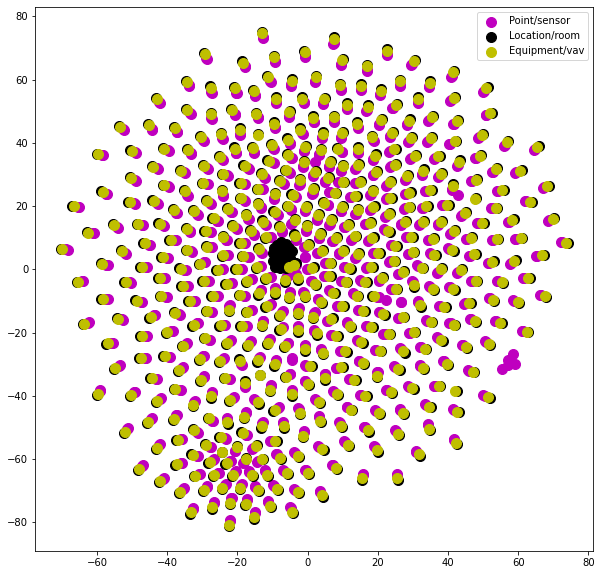

In [16]:
# inspired from https://github.com/IBCNServices/pyRDF2Vec
walk_tsne = TSNE(random_state=42)
X_tsne = walk_tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))

plt.scatter(X_tsne[0:894, 0], X_tsne[0:894, 1], s=100, marker='o', c="m", label='Point/sensor')

plt.scatter(X_tsne[894:1369, 0], X_tsne[894:1369, 1], s=100, marker='o', c="k", label='Location/room')


plt.scatter(X_tsne[1369:, 0], X_tsne[1369:, 1], s=100, marker='o', c="y", label='Equipment/vav')

plt.legend()
plt.show()

In [17]:
## convert the type of embeddngs from list to numpy array
embeddings = np.asarray(embeddings)
print("Embeddings dtype: {}\nEmbeddings shape: {}".format(type(embeddings), embeddings.shape))

Embeddings dtype: <class 'numpy.ndarray'>
Embeddings shape: (1816, 100)


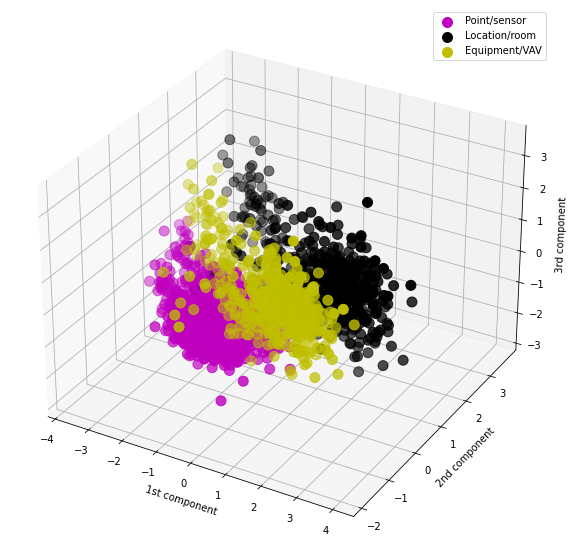

In [18]:
## using kernel PCA over derived embeddings
transformer = KernelPCA(n_components=3, kernel='linear')
X_kernel = transformer.fit_transform(embeddings)


# plot projected embeddings
#interactive plot view
#%matplotlib qt

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.set_xlabel('1st component'), ax.set_ylabel('2nd component'),ax.set_zlabel('3rd component')

ax.scatter(X_kernel[0:894, 0], X_kernel[0:894, 1], X_kernel[0:894, 2],
           s=100, marker='o', c="m", label='Point/sensor')
ax.scatter(X_kernel[894:1369, 0], X_kernel[894:1369, 1], X_kernel[894:1369, 2],
           s=100, marker='o', c="k", label='Location/room')
ax.scatter(X_kernel[1369:, 0], X_kernel[1369:, 1],X_kernel[1369:, 2],
           s=100, marker='o', c="y", label='Equipment/VAV')

plt.legend()
plt.show()

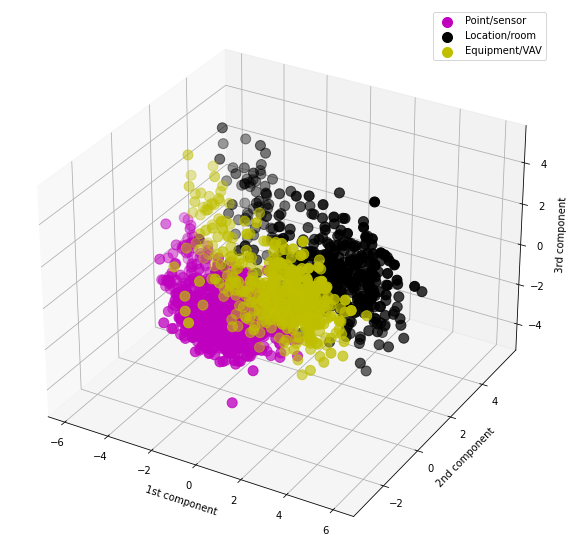

In [19]:
## robust scaling + PCA

# apply robust scaler to compensate for outliers
X = embeddings
transformer = RobustScaler().fit(X)
transformer
emb_robust = transformer.transform(X)

# apply PCA 
pca = PCA(n_components=3)
X_pca = pca.fit(emb_robust).transform(emb_robust)


# plot transformed embeddings
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.set_xlabel('1st component'), ax.set_ylabel('2nd component'),ax.set_zlabel('3rd component')


ax.scatter(X_pca[0:894, 0], X_pca[0:894, 1], X_pca[0:894, 2],
           s=100, marker='o', c="m", label='Point/sensor')

ax.scatter(X_pca[894:1369, 0], X_pca[894:1369, 1], X_pca[894:1369, 2],
           s=100, marker='o', c="k", label='Location/room')


ax.scatter(X_pca[1369:, 0], X_pca[1369:, 1],X_pca[1369:, 2],
           s=100, marker='o', c="y", label='Equipment/VAV')

plt.legend()
plt.show()

In [20]:
# compare explained variance for three principal components
print("Explained variance when linear PCA used: %.2f\nExplained variance when kernel PCA used: %.2f" % 
      (X_pca.var(), X_kernel.var()))

Explained variance when linear PCA used: 2.72
Explained variance when kernel PCA used: 1.14


# Node classification

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [22]:
## update dataframe 
# drop the rows with undiscoverable entities
drop_indx = df[df.type_entity.apply(lambda entity: entity in not_found)].index
df = df.drop(index=drop_indx)
df.describe()

,type_entity,type_label,parent_class
count,1816,1816,1816
unique,1816,3,3
top,http://cmu.edu/building/ontology/ghc#SCSC_Gate...,sensor,point
freq,1,894,894


In [36]:
## prepare training and test sets 

#reducing feature vector dimension to 50
transformer = KernelPCA(n_components=80, kernel='linear')
X = transformer.fit_transform(embeddings)

# change target dtype to category
y = df.parent_class.astype('category')
#print('Target data type: <{}>'.format(y.dtype))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train samples: %d \nTest samples: %d" % (x_train.shape[0],x_test.shape[0]))

Train samples: 1452 
Test samples: 364


              precision    recall  f1-score   support

   equipment       0.88      0.75      0.81        92
    location       0.83      0.86      0.85        96
       point       0.95      1.00      0.97       176

    accuracy                           0.90       364
   macro avg       0.89      0.87      0.88       364
weighted avg       0.90      0.90      0.90       364



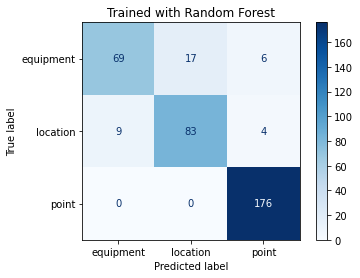

In [25]:
## “Random Forest” model development
rf_clf = RandomForestClassifier(random_state=42).fit(x_train, y_train)

y_pred = rf_clf.predict(x_test)

#matrix_plot.ax_.set_title('Trained with Random Forest')
matrix_plot = plot_confusion_matrix(rf_clf, x_test, y_test, 
                                    cmap=plt.cm.Blues).ax_.set_title('Trained with Random Forest')
#plt.savefig('egice_fig/ghc_matrix_RF.png', dpi=100)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   equipment       0.93      0.86      0.89        92
    location       0.94      0.94      0.94        96
       point       0.91      0.95      0.93       176

    accuracy                           0.92       364
   macro avg       0.93      0.92      0.92       364
weighted avg       0.92      0.92      0.92       364



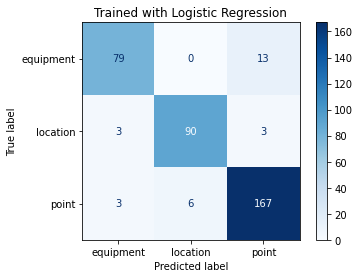

In [26]:
## “Logistic Regression” model development
logReg_clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_pred = logReg_clf.predict(x_test)

#matrix_plot.ax_.set_title('Trained with Random Forest')
matrix_plot = plot_confusion_matrix(logReg_clf, x_test, y_test, 
                                    cmap=plt.cm.Blues).ax_.set_title('Trained with Logistic Regression')
#plt.savefig('egice_fig/ghc_matrix_LogReg.png', dpi=100)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   equipment       0.98      0.87      0.92        92
    location       1.00      0.98      0.99        96
       point       0.94      1.00      0.97       176

    accuracy                           0.96       364
   macro avg       0.97      0.95      0.96       364
weighted avg       0.96      0.96      0.96       364



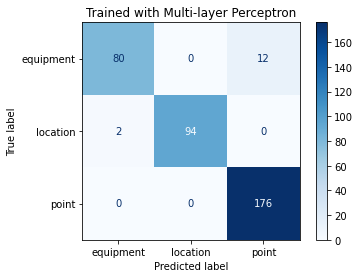

In [27]:
## “Multi-layer Perceptron” model development
mlpc_clf = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
y_pred = mlpc_clf.predict(x_test)

#matrix_plot.ax_.set_title('Trained with Random Forest')
matrix_plot = plot_confusion_matrix(mlpc_clf, x_test, y_test, 
                                    cmap=plt.cm.Blues).ax_.set_title('Trained with Multi-layer Perceptron')
#plt.savefig('egice_fig/ghc_matrix_mlpc.png', dpi=100)
print(classification_report(y_test, y_pred))

In [28]:
# review parameters for trined models
model = [rf_clf, logReg_clf, mlpc_clf]
for model in model:
    print("Used parameters for {} model:\n{}\n\n".format(str(model), model.get_params()))

Used parameters for RandomForestClassifier(random_state=42) model:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Used parameters for LogisticRegression(random_state=0) model:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Used parameters for MLPClassifier(max_iter=300, random_state=1) model:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_st

# Exploratory analysis of KG content

In [29]:
# check unique relationships within KG
query_ = """
SELECT ?p
WHERE { 
     ?s ?p ?o .
     
}
GROUP BY ?p
"""

q_res = g.query(query_)
print("({}) descriptions found:\n-----------------------".format(len(q_res)))
for row in q_res:
        print("[p]{}\n".format(row.p)) 

(9) descriptions found:
-----------------------
[p]https://brickschema.org/schema/Brick#isPointOf

[p]https://brickschema.org/schema/Brick#hasLocation

[p]https://brickschema.org/schema/Brick#hasPoint

[p]https://brickschema.org/schema/Brick#hasPart

[p]http://www.w3.org/1999/02/22-rdf-syntax-ns#type

[p]https://brickschema.org/schema/Brick#isFedBy

[p]https://brickschema.org/schema/Brick#feeds

[p]https://brickschema.org/schema/Brick#isLocationOf

[p]https://brickschema.org/schema/Brick#hasTag



In [30]:
# count total relationships described
query_ = """
SELECT ?p
WHERE { 
     ?s ?p ?o .
}
"""

q_res = g.query(query_)
print("({}) descriptions found:".format(len(q_res)))

(55733) descriptions found:


In [31]:
# count unique nodes within KG
query_ = """
SELECT ?s 
WHERE { 
     ?s a ?o .
}
GROUP BY ?s
"""

q_res = g.query(query_)
print("<{}> unique nodes found.".format(len(q_res)))

<9642> unique nodes found.


In [32]:
# get 'Discharge_Air_Flow_Sensor' descriptions 

query_ = """
SELECT ?p
WHERE { 
     ?s a brick:Discharge_Air_Flow_Sensor .
     ?s ?p ?o .
}
GROUP BY ?p
"""

q_res = g.query(query_)
print("({}) descriptions found:\n-----------------------".format(len(q_res)))
for row in q_res:
        print("[p]{}\n".format(row.p)) 

(3) descriptions found:
-----------------------
[p]http://www.w3.org/1999/02/22-rdf-syntax-ns#type

[p]https://brickschema.org/schema/Brick#hasLocation

[p]https://brickschema.org/schema/Brick#isPointOf



In [33]:
# get 'Damper_Position_Sensor' descriptions 

query_ = """
SELECT ?p
WHERE { 
     ?s a brick:Damper_Position_Sensor .
     ?s ?p ?o .
}
GROUP BY ?p
"""

q_res = g.query(query_)
print("({}) descriptions found:\n-----------------------".format(len(q_res)))
for row in q_res:
        print("[p]{}\n".format(row.p)) 

(2) descriptions found:
-----------------------
[p]http://www.w3.org/1999/02/22-rdf-syntax-ns#type

[p]https://brickschema.org/schema/Brick#isPointOf



In [34]:
# get 'Room' descriptions 

query_ = """
SELECT ?p
WHERE { 
     ?s a brick:Room .
     ?s ?p ?o .
}
GROUP BY ?p
"""

q_res = g.query(query_)
print("({}) descriptions found:\n-----------------------".format(len(q_res)))
for row in q_res:
        print("[p]{}\n".format(row.p)) 

(6) descriptions found:
-----------------------
[p]http://www.w3.org/1999/02/22-rdf-syntax-ns#type

[p]https://brickschema.org/schema/Brick#hasPart

[p]https://brickschema.org/schema/Brick#hasPoint

[p]https://brickschema.org/schema/Brick#isFedBy

[p]https://brickschema.org/schema/Brick#isLocationOf

[p]https://brickschema.org/schema/Brick#isPointOf



In [35]:
# get 'VAV' descriptions 

query_ = """
SELECT ?p
WHERE { 
     ?s a brick:VAV .
     ?s ?p ?o .
}
GROUP BY ?p
"""

q_res = g.query(query_)
print("({}) descriptions found:\n-----------------------".format(len(q_res)))
for row in q_res:
        print("[p]{}\n".format(row.p)) 

(3) descriptions found:
-----------------------
[p]http://www.w3.org/1999/02/22-rdf-syntax-ns#type

[p]https://brickschema.org/schema/Brick#feeds

[p]https://brickschema.org/schema/Brick#hasPoint

